# Deep Learning Project : Brain Tumor Semantic Segmentation
### Eman Said Al-Hajri
### AI and Data Science Stream

- The project aims to identify tumor regions accurately in Brain within Medical Images using advanced techniques.

- Classes:

   *  Tumor (Class 1)
   *  Non-Tumor (Class 0)

- Reference: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/data

--------------

### 1. Load Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import os
import matplotlib.pyplot as plt
import skimage.io
import random
import cv2

### 2. Load Dataset

In [57]:
train_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/train2/'
test_path = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/test2/'
val_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/valid2/'

In [58]:
train_images = [image for image in os.listdir(train_path) if image[-3:] =='jpg' ]
test_images = [image for image in os.listdir(test_path) if image[-3:] =='jpg' ]
val_images = [image for image in os.listdir(val_path) if image[-3:] =='jpg' ]
len(train_images),len(test_images),len(val_images)

(1402, 206, 418)

In [59]:
trainMask_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/train_masks2/'
testMask_path = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/test_masks2/'
valMask_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/val_masks2/'

In [60]:
train_masks = [image for image in os.listdir(trainMask_path) if image[-3:] =='jpg' ]
test_masks = [image for image in os.listdir(testMask_path) if image[-3:] =='jpg' ]
val_masks = [image for image in os.listdir(valMask_path) if image[-3:] =='jpg' ]
len(train_masks),len(test_masks),len(val_masks)

(1402, 206, 418)

In [62]:
train_images = sorted([f for f in os.listdir(train_path) if f.endswith('jpg')])
train_masks  = sorted([f for f in os.listdir(trainMask_path) if f.endswith('jpg')])

val_images   = sorted([f for f in os.listdir(val_path) if f.endswith('jpg')])
val_masks    = sorted([f for f in os.listdir(valMask_path) if f.endswith('jpg')])

test_images  = sorted([f for f in os.listdir(test_path) if f.endswith('jpg')])
test_masks   = sorted([f for f in os.listdir(testMask_path) if f.endswith('jpg')])

# Check matching lengths
print(f"Train: {len(train_images)} images, {len(train_masks)} masks")
print(f"Val: {len(val_images)} images, {len(val_masks)} masks")
print(f"Test: {len(test_images)} images, {len(test_masks)} masks")

Train: 1402 images, 1402 masks
Val: 418 images, 418 masks
Test: 206 images, 206 masks


### 3. Explore and Preprocess the Data

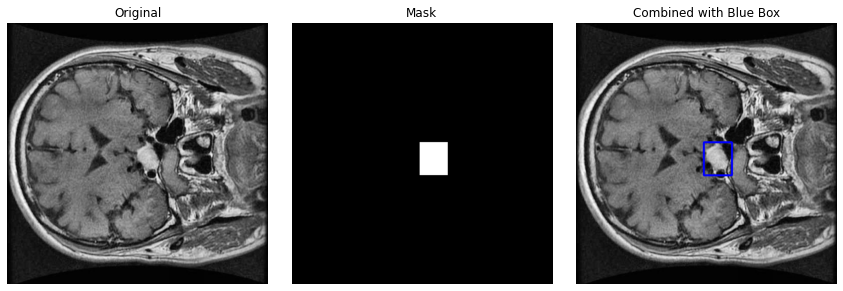

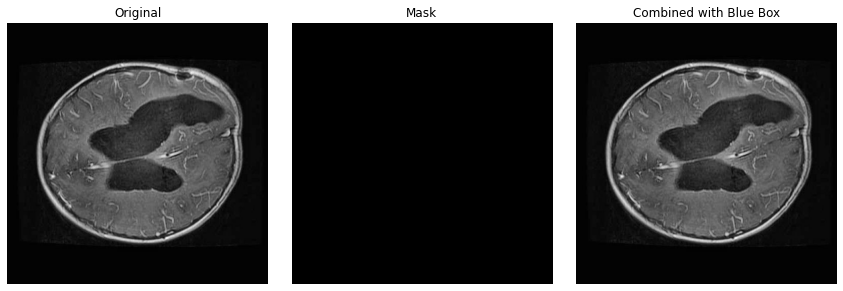

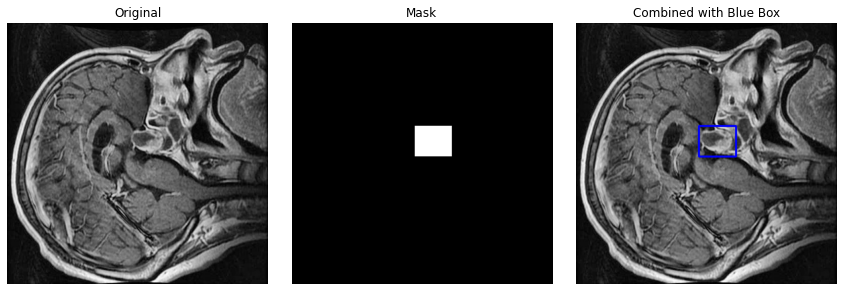

In [64]:
def display_random_images_with_masks_and_boxes(image_dir, mask_dir, num_samples=3):

    image_files = [img for img in os.listdir(image_dir) if img.endswith('.jpg')]
    mask_files = [img for img in os.listdir(mask_dir) if img.endswith('.jpg')]


    selected_images = random.sample(image_files, num_samples)

    for img_name in selected_images:
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)


        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        if mask.shape != image.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))


        _, binary_mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)


        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        combined = image_rgb.copy()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(combined, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=3)


        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(combined)
        plt.title('Combined with Blue Box')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


display_random_images_with_masks_and_boxes(val_path, valMask_path)


### 4. Split the Data

In [9]:

def load_data(image_dir, mask_dir, num_samples, target_size=(512, 512)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:num_samples]
    mask_files  = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg')])[:num_samples]

    X, y = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            image = cv2.resize(image, target_size)
            mask = cv2.resize(mask, target_size)
            X.append(image)
            y.append(mask)
        else:
            print(f"[Skipped] {img_file} or {mask_file}")

    X = np.array(X, dtype=np.float32) / 255.0
    y = np.expand_dims(np.array(y, dtype=np.float32) / 255.0, axis=-1)
    y = (y > 0.5).astype(np.float32)
    return X, y

In [10]:
import numpy as np
X_train, y_train = load_data(train_path, trainMask_path, 500)
X_val, y_val = load_data(val_path, valMask_path, 250)
X_test, y_test = load_subset(test_path, testMask_path, 200)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (500, 512, 512, 3) (500, 512, 512, 1)
Val: (250, 512, 512, 3) (250, 512, 512, 1)
Test: (200, 512, 512, 3) (200, 512, 512, 1)


In [11]:
import tensorflow as tf

def resize_dataset(images, masks, new_size=(128, 128)):
    images_resized = tf.image.resize(images, new_size)
    masks_resized = tf.image.resize(masks, new_size, method='nearest')  # use nearest to preserve mask classes
    return images_resized.numpy(), masks_resized.numpy()

X_train, y_train = resize_dataset(X_train, y_train)
X_val, y_val = resize_dataset(X_val, y_val)
X_test, y_test = resize_dataset(X_test, y_test)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


2025-07-06 13:23:12.965397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-06 13:23:13.174846: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-06 13:23:13.177253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-06 13:23:16.090421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-07-06 13:23:18.872942: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2025-07-06 13:23:21.543442: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 524288000 exceeds 10% of free system memory.
2025-07-06 

Train: (500, 128, 128, 3) (500, 128, 128, 1)
Val: (250, 128, 128, 3) (250, 128, 128, 1)
Test: (200, 128, 128, 3) (200, 128, 128, 1)


### 5. Define the Model Architecture

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models


def downsample(fm):
    # Con 1*1 s=1
    

def conv_block(inputs, filters):
    x = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    downsample(int(filters * 0.5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Taking first input and implementing the second conv block
    x2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)
    return x2

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, filters):
    x = layers.Conv2DTranspose(filters, kernel_size=(2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_model(f,input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, f)
    b1 = layers.Dropout(0.01)(b1)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model


In [13]:
model = build_model(1024, input_shape=(128, 128, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 re_lu_9 (ReLU)                 (None, 8, 8, 1024)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 dropout (Dropout)              (None, 8, 8, 1024)   0           ['re_lu_9[0][0]']                
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['dropout[0][0]']                
 ose)                                                                                             
                                                                                                  
 concatena

                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 re_lu_17 (ReLU)                (None, 128, 128, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 1)  65          ['re_lu_17[0][0]']               
                                                                                                  
Total para

In [14]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

def iou(y_true, y_pred, smooth=1e-7):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

### 6. Compile the Model

In [15]:
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=['accuracy', dice_coefficient, iou])


### 7. Train the Model

In [16]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=8)

Epoch 1/15
63/63 [==============================] - 740s 11s/step - loss: 0.7529 - accuracy: 0.9089 - dice_coefficient: 0.2492 - iou: 0.1469 - val_loss: 0.9592 - val_accuracy: 0.0335 - val_dice_coefficient: 0.0398 - val_iou: 0.0205
Epoch 2/15
63/63 [==============================] - 700s 11s/step - loss: 0.4885 - accuracy: 0.9789 - dice_coefficient: 0.5125 - iou: 0.3509 - val_loss: 0.8886 - val_accuracy: 0.7827 - val_dice_coefficient: 0.1088 - val_iou: 0.0588
Epoch 3/15
63/63 [==============================] - 695s 11s/step - loss: 0.3915 - accuracy: 0.9827 - dice_coefficient: 0.6090 - iou: 0.4425 - val_loss: 0.9442 - val_accuracy: 0.3311 - val_dice_coefficient: 0.0544 - val_iou: 0.0282
Epoch 4/15
63/63 [==============================] - 695s 11s/step - loss: 0.3557 - accuracy: 0.9841 - dice_coefficient: 0.6433 - iou: 0.4814 - val_loss: 0.8226 - val_accuracy: 0.9148 - val_dice_coefficient: 0.1733 - val_iou: 0.0980
Epoch 5/15
63/63 [==============================] - 696s 11s/step - loss

### 8. Predict and Evaluate the Model

In [17]:
def test_accuracy(model,X_test, y_test):
    batch_size = 8
    predictions = model.predict(X_test, batch_size=batch_size)

    y_pred = np.squeeze(predictions)
    y_pred = np.expand_dims(y_pred, axis=-1)

    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(np.float32)

    accuracy = np.mean(y_pred_binary == y_test)

    dice_coefficient_score = dice_coefficient(y_test, y_pred)
    dice_loss_score = dice_loss(y_test, y_pred)
    iou_result = iou(y_test, y_pred)
    print(f"Pixel-wise Accuracy: {accuracy:.4f}")
    print(f'Dice Coefficient: {dice_coefficient_score:.4f}')
    print(f'Dice Loss: {dice_loss_score:.4f}')
    print(f'Iou Result: {iou_result:.4f}')


In [18]:
test_accuracy(model,X_test, y_test)

25/25 [==============================] - 61s 2s/step
Pixel-wise Accuracy: 0.9902
Dice Coefficient: 0.4471
Dice Loss: 0.5529
Iou Result: 0.2879


In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    dice = history.history['dice_coefficient']
    val_dice = history.history['val_dice_coefficient']

    epochs = range(1, len(loss) + 1)

    # Loss
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss,  label='Training loss')
    plt.plot(epochs, val_loss,  label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dice,  label='Training Dice')
    plt.plot(epochs, val_dice, label='Validation Dice')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

### 10. Evaluate the Model and Visualize Results (Metrics/Predictions)

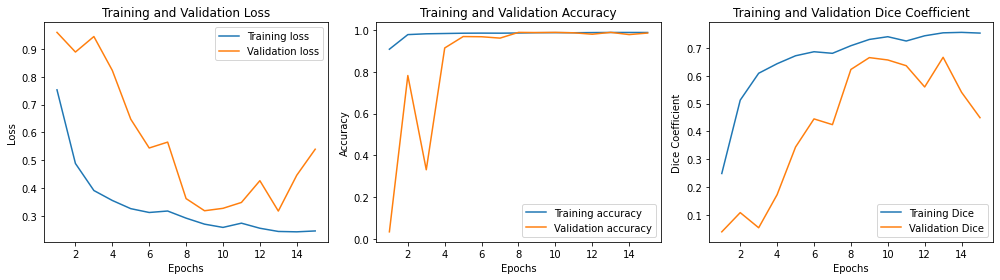

In [20]:
plot_training_history(history)

### 11. Make Predictions

In [30]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def test_random_images(model, test_path , testMask_path, n=5):
   

    test_images = sorted([f for f in os.listdir(test_path) if f.endswith('.jpg')])

    indices = np.random.choice(len(test_images), size=n, replace=False)

    plt.figure(figsize=(12, 4 * n))
    j = 1
    for idx in indices:
        img_name = test_images[idx]

        img_path = os.path.join(test_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (128, 128))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        input_array = np.expand_dims(image / 255.0, axis=0)
        mask_pred = model.predict(input_array)[0]
        mask_pred = (mask_pred > 0.5).astype(np.float32) * 255

        mask_path = os.path.join(testMask_path, img_name)
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, (128, 128))

        plt.subplot(n, 3, j)
        plt.imshow(image_rgb)
        plt.title("Input Image")
        plt.axis('off')
        j += 1

        plt.subplot(n, 3, j)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        j += 1

        plt.subplot(n, 3, j)
        plt.imshow(mask_pred.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        j += 1

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 419ms/step


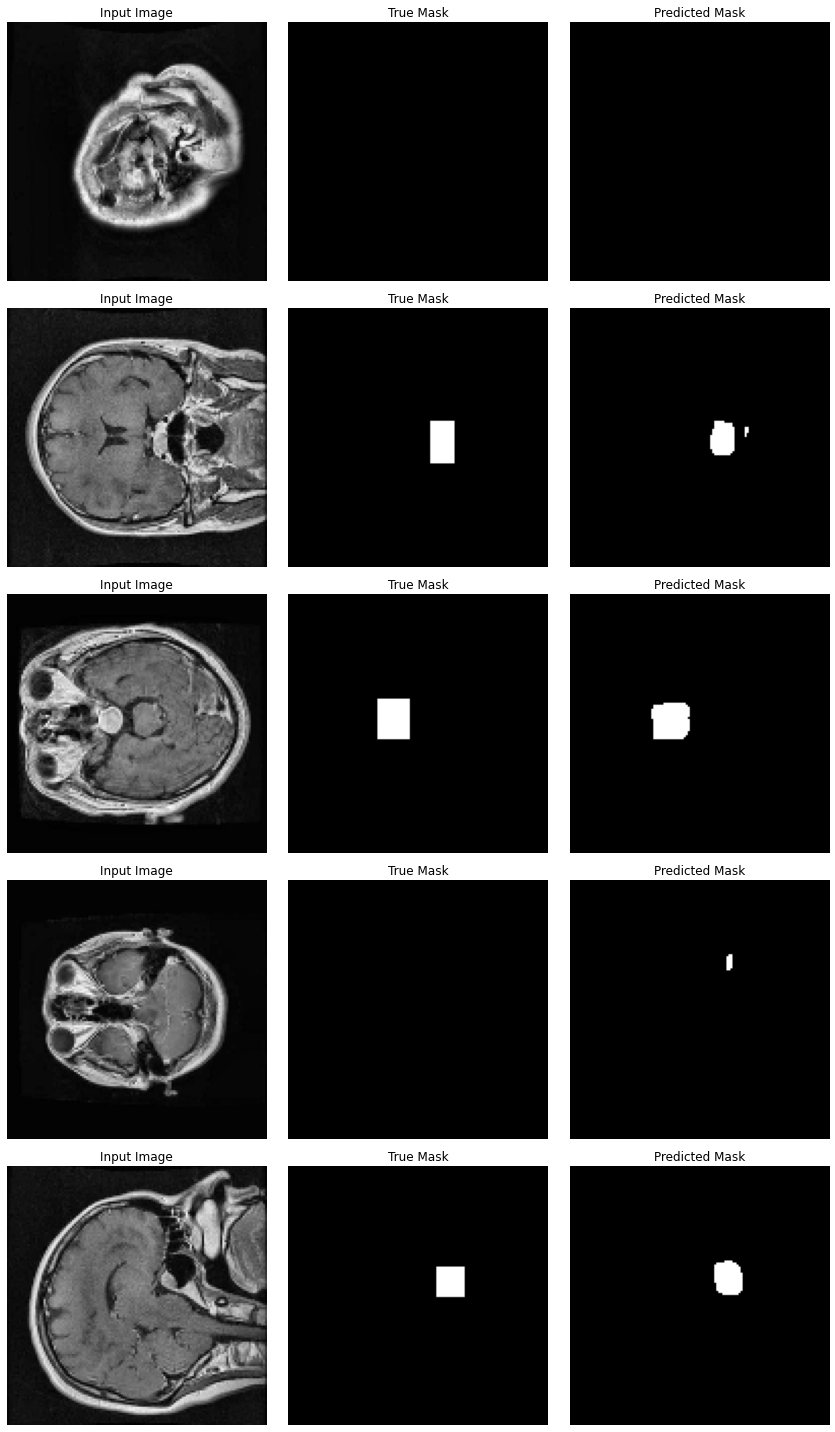

In [48]:
test_random_images(model, test_path , testMask_path)

### 12. Fine-Tune and Optimize

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , Callback , EarlyStopping, ModelCheckpoint

optimizer = Adam(learning_rate=1e-4)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [41]:

def combined_loss(y_true, y_pred):
    return (0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)) + (0.5 * dice_loss(y_true, y_pred))


In [42]:
model2 = build_model(512, input_shape=(128, 128, 3))

model2.compile(optimizer=optimizer,
              loss=combined_loss,
              metrics=['accuracy', dice_coefficient, iou])


In [43]:

history2 = model2.fit(
     x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
63/63 [==============================] - 662s 10s/step - loss: 0.6228 - accuracy: 0.9182 - dice_coefficient: 0.1100 - iou: 0.0589 - val_loss: 0.7299 - val_accuracy: 0.9793 - val_dice_coefficient: 0.0366 - val_iou: 0.0188 - lr: 1.0000e-04
Epoch 2/20
63/63 [==============================] - 648s 10s/step - loss: 0.4686 - accuracy: 0.9812 - dice_coefficient: 0.2281 - iou: 0.1293 - val_loss: 0.6237 - val_accuracy: 0.9793 - val_dice_coefficient: 0.0300 - val_iou: 0.0153 - lr: 1.0000e-04
Epoch 3/20
63/63 [==============================] - 718s 11s/step - loss: 0.4250 - accuracy: 0.9842 - dice_coefficient: 0.2810 - iou: 0.1644 - val_loss: 0.5755 - val_accuracy: 0.9793 - val_dice_coefficient: 0.0291 - val_iou: 0.0148 - lr: 1.0000e-04
Epoch 4/20
63/63 [==============================] - 656s 10s/step - loss: 0.3887 - accuracy: 0.9864 - dice_coefficient: 0.3287 - iou: 0.1978 - val_loss: 0.5563 - val_accuracy: 0.9793 - val_dice_coefficient: 0.0271 - val_iou: 0.0138 - lr: 1.0000e-04
Epoc

In [44]:
test_accuracy(model2,X_test, y_test)

25/25 [==============================] - 61s 2s/step
Pixel-wise Accuracy: 0.9929
Dice Coefficient: 0.5371
Dice Loss: 0.4629
Iou Result: 0.3672


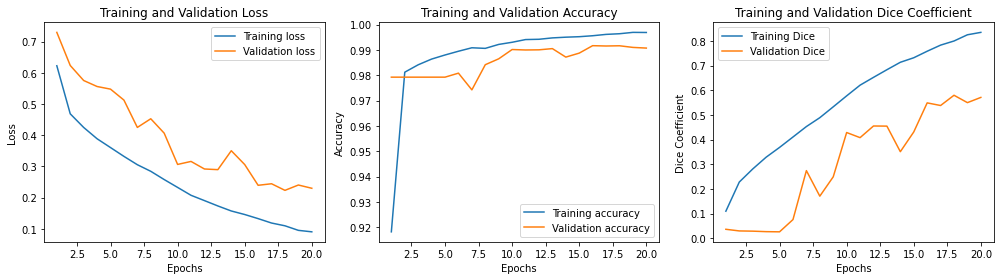

In [45]:
plot_training_history(history2)

1/1 [==============================] - 0s 366ms/step


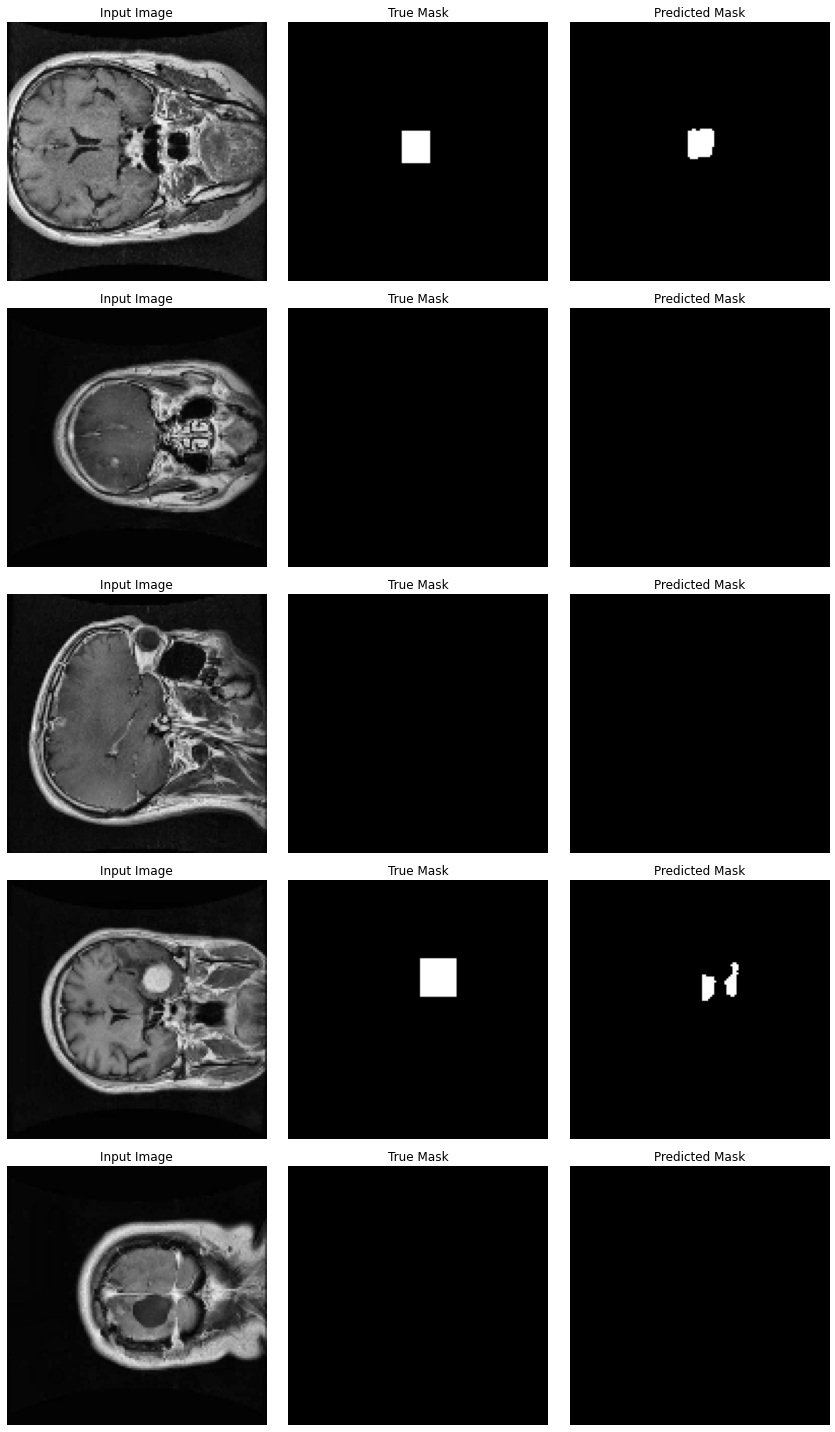

In [49]:
test_random_images(model2, test_path , testMask_path)

### 12. Save and Load the Model